# Starting point
## Maximum amplitude map compared against TPXO 7.2 solution
What I try do achive is a comparison of maximum tidal amplitude from ROMS against the TPXO7.2 solution (provides forcing for ROMS). To do so, I compare ROMS maximum sea surface height anomaly from a hourly record of 14 days against the summation of the amplitudes over all (8) constituents from the forcing file. 

In [11]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

file_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','ocean_his_hourly.nc')
ds = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ampl_max = ds.zeta.max('ocean_time')-ds.zeta.mean('ocean_time')

In [12]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_dataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_ampl_max = dsf.sum('tide_period')

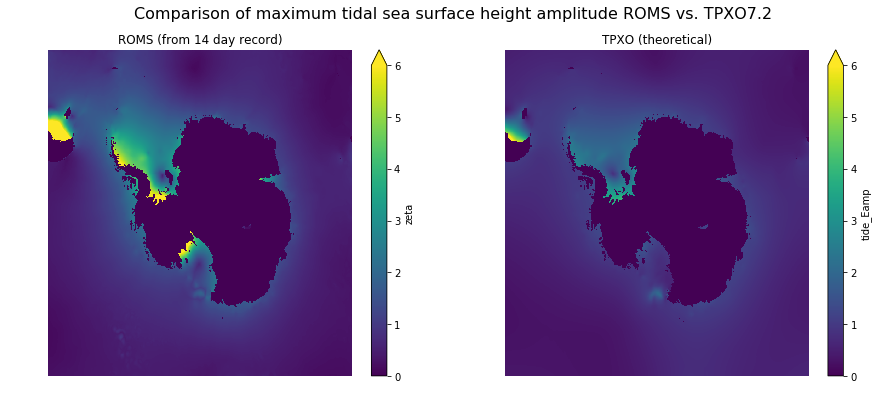

In [13]:
# plot both next to each other with same colorbounds
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=6)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=6)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

... Roms gets about two times to high under the big ice shelves. Since the height looks ok everywhere else, this might be related to the kelvin waves. Two ideas to fix this:
1. no forcing on the continental shelf
2. increase bottom/ice shelf drag, high resolution might help

## Comparison of M2 and O1 amplitude maps
(others violate Rayleigh condition with just 14 day record) 
Apply t_tide tidal harmonic analysis on every grid point and fill O1 and M2 amplitude maps in Xarray dataset.
First define the function

In [40]:
import ttide as tt
import numpy as np
import pandas as pd

def O1_M2_ampl(ds,xi_values,eta_values):
    ds['O1_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))
    ds['M2_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))

    #stime = datetime(1996,12,31,1)
    stime = pd.to_datetime(ds.ocean_time[0].values)

    for xi in xi_values:
        print('processing xi: ',xi)
        for eta in eta_values:

            ds_sl = ds.isel(eta_rho=eta,xi_rho=xi)

            if ds_sl.zeta.isnull().values.any():
                ds.O1_ampl[eta,xi] = np.NaN
                ds.M2_ampl[eta,xi] = np.NaN
            else:
                signal = ds_sl.zeta.values
                latitude = ds_sl.lat_rho.values
                try:
                    ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

                    ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
                    ind_M2 = list(ttide_out['nameu']).index(b'M2  ')

                    O1_ampl = ttide_out['tidecon'][ind_O1][0]
                    M2_ampl = ttide_out['tidecon'][ind_M2][0]

                    ds.O1_ampl[eta,xi] = O1_ampl
                    ds.M2_ampl[eta,xi] = M2_ampl

                except TypeError:

                    ds.O1_ampl[eta,xi] = np.NaN
                    ds.M2_ampl[eta,xi] = np.NaN
                    
    return ds

then apply to dataset.

In [ ]:
ds = O1_M2_ampl(ds,ds.xi_rho.values,ds.eta_rho.values)

processing xi:  0
processing xi:  1
processing xi:  2
processing xi:  3
processing xi:  4
processing xi:  5
processing xi:  6
processing xi:  7
processing xi:  8
processing xi:  9
processing xi:  10
processing xi:  11
processing xi:  12


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:619: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
processing xi:  13
processing xi:  14


Plot against TPXO O1 and M2 amplitude maps

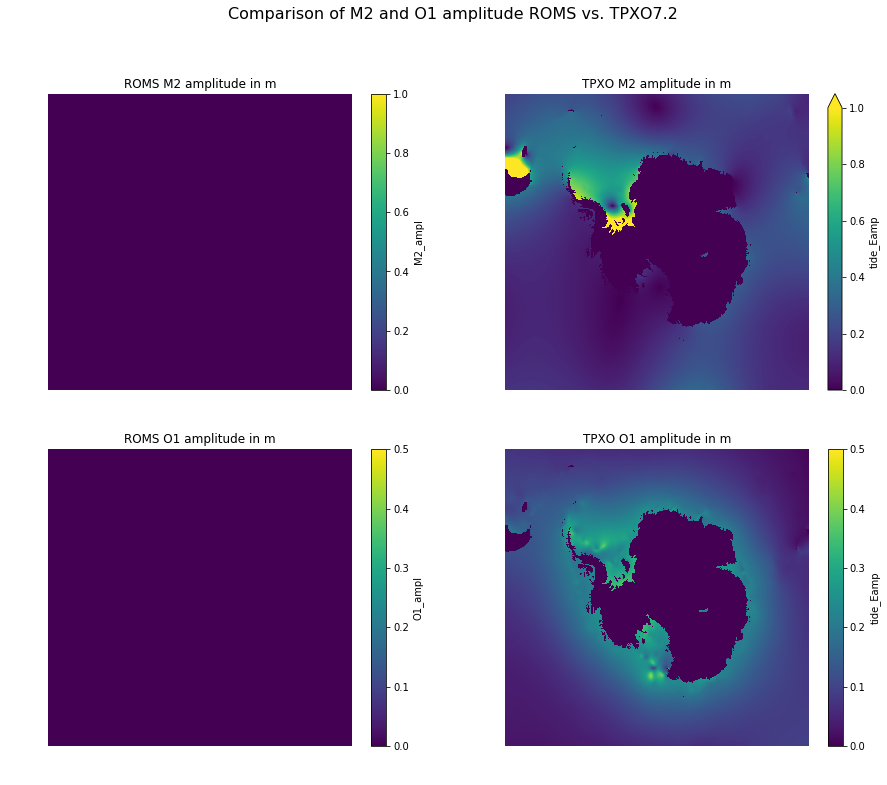

In [50]:
plt.close('all')
fig,axes = plt.subplots(2,2,figsize=(15,12))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 amplitude ROMS vs. TPXO7.2',fontsize=16)
ds.M2_ampl.fillna(0).plot(ax=ax1,vmax=1)
ax1.set_title('ROMS M2 amplitude in m')
ax1.axis('off')
dsf.tide_Eamp[0].plot(ax=ax2,vmax=1)
ax2.set_title('TPXO M2 amplitude in m')
ax2.axis('off')
ds.O1_ampl.fillna(0).plot(ax=ax3,vmax=0.5)
ax3.set_title('ROMS O1 amplitude in m')
ax3.axis('off')
dsf.tide_Eamp[5].plot(ax=ax4,vmax=0.5)
ax4.set_title('TPXO O1 amplitude in m')
ax4.axis('off')
plt.show()

... both are unacceptable to high.

# No forcing under the ice shelves
Dave suggested that the to high tides might come from some model amplification under the ice shelves. Therefore I look at an experiment, without tidal surface forcing where ice shelf is present.
## Generating the tidal mask

In [17]:
#mask tidal forcing
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)
#Pamp_masked = pott_ds.tide_Pamp.where((grid_ds.zice.values == 0.0 ,0.0))
#plt.close()
#Pamp_masked[2].plot()
#plt.show()

## Effect on max surface height anomaly

In [10]:
out_path = os.path.join(pott_path,os.pardir,'waom10_ptds_masked.nc')
pott_ds['tide_Pamp']=Pamp_masked
pott_ds.to_netcdf(out_path,'w')

NameError: name 'Pamp_masked' is not defined

In [18]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_0006.nc')
ds_tm = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_tm_ampl_max = ds_tm.zeta[336:].max('ocean_time')-ds_tm.zeta[336:].mean('ocean_time')

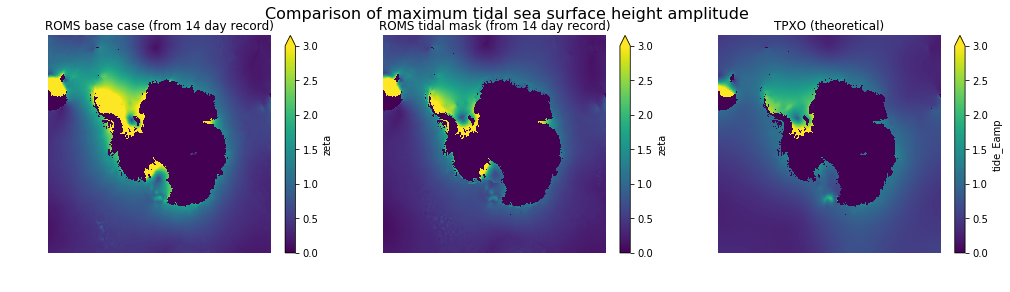

In [19]:
# plot against base case and tpxo
plt.clf()
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=3)
ax1.set_title('ROMS base case (from 14 day record)')
ax1.axis('off')
roms_tm_ampl_max.fillna(0).plot(ax=ax2,vmax=3)
ax2.set_title('ROMS tidal mask (from 14 day record)')
ax2.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=3)
ax3.set_title('TPXO (theoretical)')
ax3.axis('off')
plt.show()

... this looks a lot better, though its still ssh amplitudes are still to high in the shallow areas under the ice shelves.
## M2 and O1 maps

In [46]:
ds_tm = O1_M2_ampl(ds_tm,ds_tm.xi_rho.values,ds_tm.eta_rho.values)

processing xi:  0
processing xi:  1
processing xi:  2
processing xi:  3
processing xi:  4
processing xi:  5
processing xi:  6
processing xi:  7
processing xi:  8
processing xi:  9
processing xi:  10
processing xi:  11
processing xi:  12


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:619: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
processing xi:  13
processing xi:  14
processing xi:  15
processing xi:  16
processing xi:  17
processing xi:  18
processing xi:  19
processing xi:  20
processing xi:  21
processing xi:  22
processing xi:  23
processing xi:  24
processing xi:  25
processing xi:  26
processing xi:  27
processing xi:  28
processing xi:  29
processing xi:  30
processing xi:  31
processing xi:  32
processing xi:  33
processing xi:  34
processing xi:  35
processing xi:  36
processing xi:  37
processing xi:  38
processing xi:  39
processing xi:  40
processing xi:  41
processing xi:  42
processing xi:  43
processing xi:  44
processing xi:  45
processing xi:  46
processing xi:  47
processing xi:  48
processing xi:  49
processing xi:  50
processing xi:  51
processing xi:  52
processing xi:  53
processing xi:  54
processing xi:  55
processing xi:  56
processing xi:  57
processing xi:  58
processing xi:  59
processing xi:  60
processing xi:  61
processing xi:  62
processing xi:  63
pr

processing xi:  426
processing xi:  427
processing xi:  428
processing xi:  429
processing xi:  430
processing xi:  431
processing xi:  432
processing xi:  433
processing xi:  434
processing xi:  435
processing xi:  436
processing xi:  437
processing xi:  438
processing xi:  439
processing xi:  440
processing xi:  441
processing xi:  442
processing xi:  443
processing xi:  444
processing xi:  445
processing xi:  446
processing xi:  447
processing xi:  448
processing xi:  449
processing xi:  450
processing xi:  451
processing xi:  452
processing xi:  453
processing xi:  454
processing xi:  455
processing xi:  456
processing xi:  457
processing xi:  458
processing xi:  459
processing xi:  460
processing xi:  461
processing xi:  462
processing xi:  463
processing xi:  464
processing xi:  465
processing xi:  466
processing xi:  467
processing xi:  468
processing xi:  469
processing xi:  470
processing xi:  471
processing xi:  472
processing xi:  473
processing xi:  474
processing xi:  475


processing xi:  836
processing xi:  837
processing xi:  838
processing xi:  839
processing xi:  840
processing xi:  841
processing xi:  842
processing xi:  843
processing xi:  844
processing xi:  845
processing xi:  846
processing xi:  847
processing xi:  848
processing xi:  849
processing xi:  850
processing xi:  851
processing xi:  852
processing xi:  853
processing xi:  854
processing xi:  855
processing xi:  856
processing xi:  857
processing xi:  858
processing xi:  859
No predictions with this SNR
No predictions with this SNR


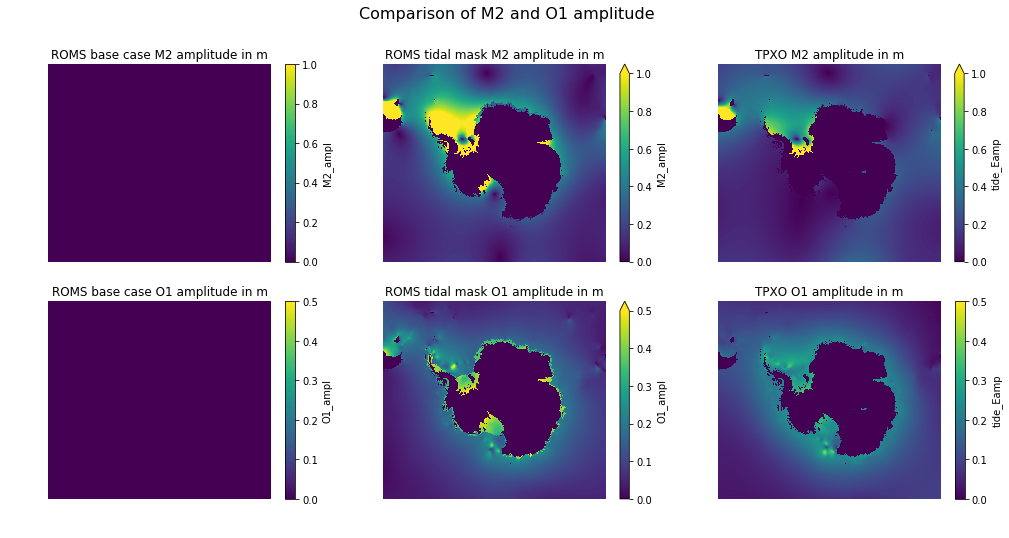

In [47]:
plt.close('all')
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 amplitude',fontsize=16)

ds.M2_ampl.fillna(0).plot(ax=ax1,vmax=1)
ax1.set_title('ROMS base case M2 amplitude in m')
ax1.axis('off')

ds_tm.M2_ampl.fillna(0).plot(ax=ax2,vmax=1)
ax2.set_title('ROMS tidal mask M2 amplitude in m')
ax2.axis('off')

dsf.tide_Eamp[0].plot(ax=ax3,vmax=1)
ax3.set_title('TPXO M2 amplitude in m')
ax3.axis('off')


ds.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
ax4.set_title('ROMS base case O1 amplitude in m')
ax4.axis('off')

ds_tm.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
ax5.set_title('ROMS tidal mask O1 amplitude in m')
ax5.axis('off')

dsf.tide_Eamp[5].plot(ax=ax6,vmax=0.5)
ax6.set_title('TPXO O1 amplitude in m')
ax6.axis('off')

plt.show()

...

# 5x Drag coefficient
Ramping up the drag coefficent from 0.003 to 0.015 to represent conversion to internal tides, which is not present in 10 km model run.
## Maximum sea surface height anomaly

In [4]:
#look at results
file_path = os.path.join(os.pardir,'data','raw','waom10_tidal_mask','ocean_his_5xCd_0006.nc')
ds_Cd = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_Cd_ampl_max = ds_Cd.zeta[336:].max('ocean_time')-ds_Cd.zeta[336:].mean('ocean_time')

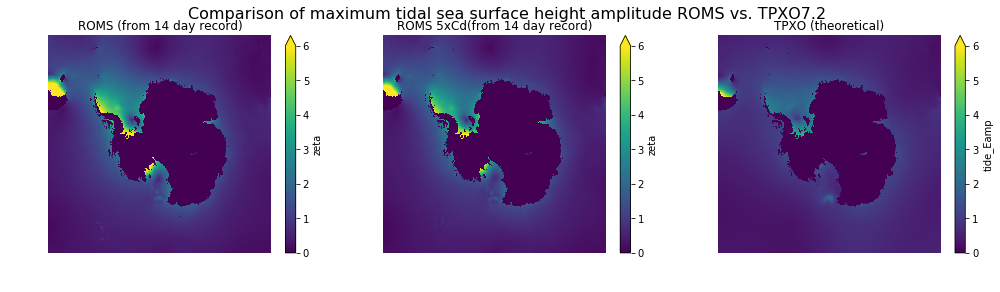

In [5]:
# plot against tpxo as before
plt.clf()
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=6)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
roms_Cd_ampl_max.fillna(0).plot(ax=ax2,vmax=6)
ax2.set_title('ROMS 5xCd(from 14 day record)')
ax2.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=6)
ax3.set_title('TPXO (theoretical)')
ax3.axis('off')
plt.show()

... visible, but small decrease in max amplitude.
# 2x viscosity
Ramping up the visc2 from 500 m^2/s to 1000 m^2/s.

In [5]:
#look at results
import os
import xarray as xr
#file_path = os.path.join(os.pardir,'data','raw','waom10_tidal_mask','ocean_his_2xVisc2_0006.nc')
file_path = '/home/ubuntu/ocean_his_2xVisc2_0006.nc'
ds_Vi = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_Vi_ampl_max = ds_Vi.zeta[336:].max('ocean_time')-ds_Vi.zeta[336:].mean('ocean_time')

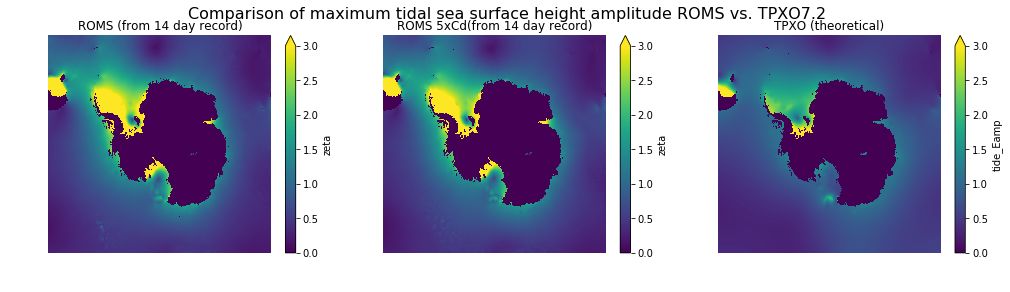

In [8]:
# plot against tpxo as before
plt.clf()
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=3)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
roms_Vi_ampl_max.fillna(0).plot(ax=ax2,vmax=3)
ax2.set_title('ROMS 5xCd(from 14 day record)')
ax2.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=3)
ax3.set_title('TPXO (theoretical)')
ax3.axis('off')
plt.show()

... almost no impact.
# Mask shallow
Masking shallow areas (including all artificially deepened cells) by setting mask_rho == 0 where wct <= 50 m.

In [27]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
import os
import sys
# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from features.uvp_masks import uvp_masks
%autoreload uvp_masks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
grid_path = os.path.join(oos.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_mask.nc')
grd_ds = xr.open_dataset(grid_path)
rmask = grd_ds.mask_rho

In [20]:
mask_new = rmask.where(grd_ds.h + grd_ds.zice > 50,0)
rmask_val = mask_new.values
umask,vmask,pmask = uvp_masks(rmask)

In [21]:
import netCDF4 as nc
out_path = '/home/ubuntu/raijin/short/m68/oxr581/waom10_tidal_mask/Data/waom10/waom10_grd_mask.nc'
id = nc.Dataset(out_path,'a')
id.variables['mask_rho'][:,:]=rmask_val
id.variables['mask_u'][:,:]= umask
id.variables['mask_v'][:,:]= vmask
id.variables['mask_psi'][:,:]= pmask
id.close()

In [29]:
#look at results
import os
import xarray as xr
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_ms_0006.nc')
ds_ms = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ms_ampl_max = ds_ms.zeta[336:].max('ocean_time')-ds_ms.zeta[336:].mean('ocean_time')

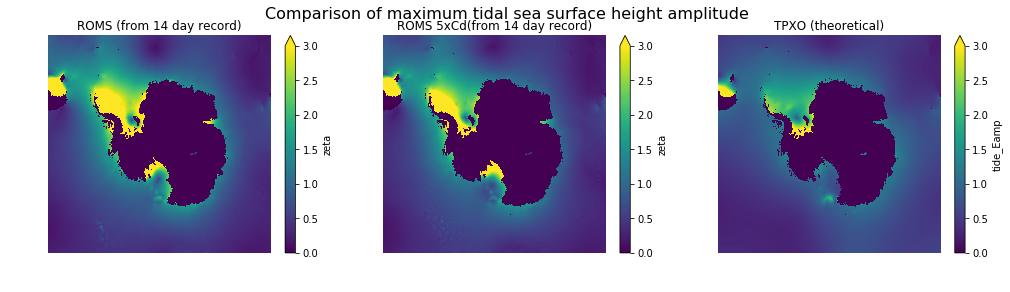

In [30]:
# plot against tpxo as before
plt.clf()
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=3)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
roms_ms_ampl_max.fillna(0).plot(ax=ax2,vmax=3)
ax2.set_title('ROMS 5xCd(from 14 day record)')
ax2.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=3)
ax3.set_title('TPXO (theoretical)')
ax3.axis('off')
plt.show()

... a bit better in the Weddell Sea and Amery. However in the Ross sea it seems just to shift the high amplitudes further in the direction of the kelvin wave propagation.

... more ideas would be trying a different vertical mixing scheme as recommended by Robin Robertson (MY and some GLS) and looking at the impact of increased resolution.

# 2x horizontal resolution
By increasing the horizontal resolution from 10km to 5km we hope to lose energy into baroclinic tides, which we don't resolve withthe coarse grid. Also better representation of bathymetry and ice draft, less smoothing and artificial deepening to only 30m water column thickness might have an impact. 

In [48]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5','ocean_his_0002.nc')
ds_hr = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_hr_ampl_max = ds_hr.zeta[:].max('ocean_time')-ds_hr.zeta[:].mean('ocean_time')

### Max tidal amplitude

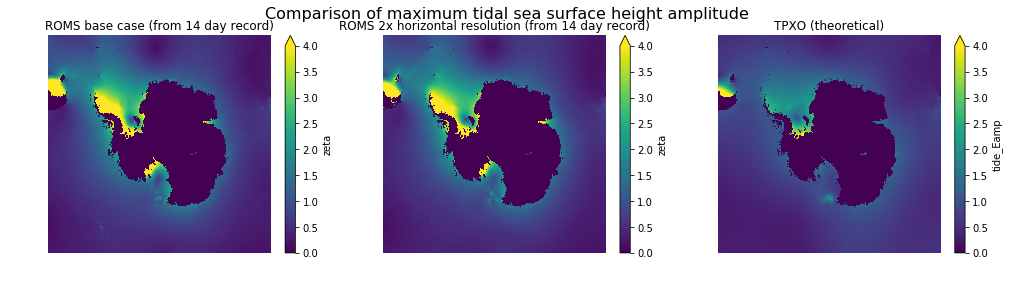

In [49]:
# plot against tpxo as before
plt.clf()
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=4)
ax1.set_title('ROMS base case (from 14 day record)')
ax1.axis('off')
roms_hr_ampl_max.fillna(0).plot(ax=ax2,vmax=4)
ax2.set_title('ROMS 2x horizontal resolution (from 14 day record)')
ax2.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=4)
ax3.set_title('TPXO (theoretical)')
ax3.axis('off')
plt.show()

### M2 O1 amplitudes

In [39]:
ds_hr = O1_M2_ampl(ds_hr,np.arange(346,808),np.arange(738,1182))

processing xi:  355


ValueError: b'O1  ' is not in list

In [ ]:
plt.close('all')
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 amplitude',fontsize=16)

ds.M2_ampl.fillna(0).plot(ax=ax1,vmax=1)
ax1.set_title('ROMS base case M2 amplitude in m')
ax1.axis('off')

ds_hr.M2_ampl.fillna(0).plot(ax=ax2,vmax=1)
ax2.set_title('ROMS high resolution M2 amplitude in m')
ax2.axis('off')

dsf.tide_Eamp[0].plot(ax=ax3,vmax=1)
ax3.set_title('TPXO M2 amplitude in m')
ax3.axis('off')


ds.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
ax4.set_title('ROMS base case O1 amplitude in m')
ax4.axis('off')

ds_hr.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
ax5.set_title('ROMS high resolution O1 amplitude in m')
ax5.axis('off')

dsf.tide_Eamp[5].plot(ax=ax6,vmax=0.5)
ax6.set_title('TPXO O1 amplitude in m')
ax6.axis('off')

plt.show()